# 리뷰감정분석


## 라이브러리 임포트


In [1]:
import os
import re
import pickle
import requests
import warnings
from tqdm import tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

In [3]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

Font directories:
	/System/Library/Assets/com_apple_MobileAsset_Font3
	/System/Library/Assets/com_apple_MobileAsset_Font4
	/System/Library/Fonts
	/Library/Fonts
	/Users/registry/Library/Fonts
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7
	/Users/registry/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/Users/registry/.fonts
	/System/Library/Fonts/Supplemental
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0818d874bf1d0e24a1fe62e79f407717792c5ee1.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/0ab217c39c45c7c6acaddfa199fd32c55a7b4a19.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/10b097deccb3c6126d986e24b1980031ff7399da.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/12cc699be28fb04f3e3c4969a0378a87b920b174.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/157acc4d862730d6d5beaa943546f80a71948c7b.asset
	/System/Library/AssetsV2/com_apple_MobileAsset_Font7/18189590ed3a5f46cef20ed4d1cec2611dca13ff.asset
	/System/L

## 데이터 로드


### TrainSet 내려받기, 저장 및 로드


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
중복 제거 전 고유 문서 수: 146182
중복 제거 후 데이터 형태: (146183, 3)


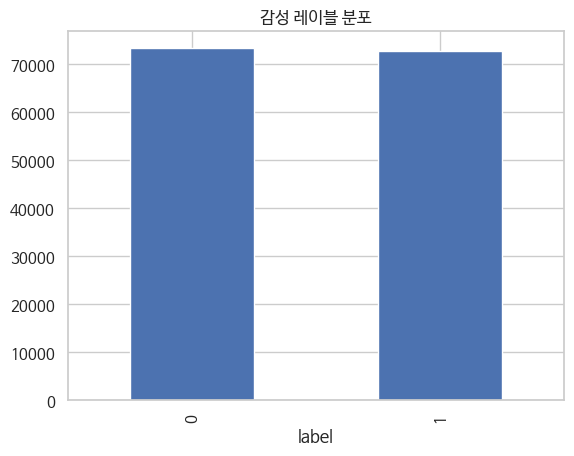

결측치 수: 0
빈 문서 수: 391
최종 데이터 형태: (145791, 3)


  5%|▍         | 7256/145791 [00:13<04:18, 536.59it/s]

In [ ]:
response = requests.get("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt")
with open("../data/mining/ratings_train.txt", "wb") as f:
  f.write(response.content)

df_train = pd.read_table("../data/mining/ratings_train.txt")
df_train.info()

# 데이터 전처리
# 1. 중복 제거
print(f"중복 제거 전 고유 문서 수: {df_train['document'].nunique()}")
df_train = df_train.drop_duplicates(subset=['document'])
print(f"중복 제거 후 데이터 형태: {df_train.shape}")

# 2. 레이블 분포 확인
df_train['label'].value_counts().plot(kind='bar')
plt.title('감성 레이블 분포')
plt.show()

# 3. 결측치 제거
df_train = df_train.dropna(how='any')
print(f"결측치 수: {df_train.isnull().values.sum()}")

# 4. 한글과 공백만 남기기
df_train['document'] = df_train['document'].apply(lambda x: re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))

# 5. 빈 문자열 처리
empty_docs_count = df_train.loc[df_train['document'] == '', 'document'].count()
print(f"빈 문서 수: {empty_docs_count}")
df_train.replace({'document': {'': np.nan}}, inplace=True)
df_train = df_train.dropna(how='any')
print(f"최종 데이터 형태: {df_train.shape}")

# 형태소 분석
okt = Okt()
X_train = []
y_train = []

# 진행 상황 표시와 함께 형태소 분석 수행
for sentence, label in tqdm(zip(df_train['document'], df_train['label']), total=len(df_train)):
  # 형태소 분리, 정규화, 어간 추출
  morphs = okt.morphs(sentence, stem=True, norm=True)
  X_train.append(morphs)
  y_train.append(label)

# 데이터 저장
with open("../data/mining/X_train.pkl", "wb") as f:
  pickle.dump(X_train, f)

with open("../data/mining/y_train.pkl", "wb") as f:
  pickle.dump(y_train, f)

print("X_train.pkl 및 y_train.pkl 파일 저장 완료!")

In [ ]:
# 훈련된 모델 및 TF-IDF 벡터라이저 불러오기
with open("../data/mining/X_train.pkl", "rb") as f:
  X_train = pickle.load(f)

with open("../data/mining/y_train.pkl", "rb") as f:
  y_train = pickle.load(f)

### TestSet 로드


In [ ]:
# 테스트 데이터 로드
df_test = pd.read_csv("../data/mining/kakao_map_place_comment.csv", encoding='utf-8-sig')

# 중복 제거
df_test = df_test.drop_duplicates(subset=['contents'])

# 한글과 공백만 남기고 정제
df_test['contents'] = df_test['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True).str.strip()

# 빈 문자열 처리
df_test['contents'] = df_test['contents'].replace('', np.nan)

# 결측치 제거
df_test = df_test.dropna(subset=['contents'])

## 데이터 전처리


In [ ]:
# TF-IDF 벡터라이저 로드
tfidf_vectorizer = TfidfVectorizer()
X_train = [' '.join(words) for words in X_train]  # 리스트를 문자열로 변환
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # 훈련 데이터 변환

In [ ]:
# 형태소 분석기 설정
okt = Okt()

# 형태소 분석 (토큰화 후 문자열로 변환) - 리스트 컴프리헨션 사용
X_test = [' '.join(okt.morphs(sentence, stem=True, norm=True)) for sentence in tqdm(df_test['contents'])]

In [ ]:
# 로지스틱 회귀 모델 로드
log_reg = LogisticRegression(max_iter=100000).fit(X_train_tfidf, y_train)

In [ ]:
# 테스트 데이터 감정 분석 및 라벨 예측
X_test_tfidf = tfidf_vectorizer.transform(X_test)  # TF-IDF 변환
predicted_labels = log_reg.predict(X_test_tfidf)  # 감정 예측

In [ ]:
# 예측된 감정 라벨을 데이터프레임에 추가
df_test['label'] = predicted_labels

In [ ]:
# 결과 확인 및 CSV 저장
print(df_test[['contents', 'label']].head(10))  # 상위 5개 데이터 확인
df_test.to_csv("../data/mining/labeled_test_data.csv", encoding='utf-8-sig', index=False)  # 결과 저장

In [ ]:
# 지역별 카테고리 설정
yg_regions = [
    '대학로', '북촌', '서촌', '홍대입구역', '합정', '연남',
    '해방촌', '경리단길', '종로3가', '성수동', '신사동 가로수길',
    '송리단길', '명동', '신림', '문래', '이수역', '용리단길'
]
ng_regions = [
    '강남역', '압구정로데오', '건대입구역', '여의도역',
    '동대문', '잠실역', '회기역', '영등포', '청담', '사당'
]
nm_regions = [
    '성내동', '시흥동', '삼양동', '중화동', '월계동',
    '응암동', '신도림동', '신정동', '도봉동', '방화동'
]

# 지역을 기반으로 카테고리 분류
def categorize_region(region):
  match region:
    case _ if region in yg_regions:
      return '젠트리피케이션'
    case _ if region in ng_regions:
      return '비젠트리피케이션'
    case _ if region in nm_regions:
      return '기본상권지'
    case _:
      return '기타'

# df_test에 지역별 카테고리 추가
df_test['category'] = df_test['region'].apply(categorize_region)

# '기타' 지역 제외
df_test = df_test[df_test['category'] != '기타']

In [ ]:
df_test.head()

In [ ]:
df_price_gen = df_test[df_test['category'] == '젠트리피케이션'][['contents', 'label']]
df_price_gen[df_price_gen['contents'].str.contains('가격', na=False)]['label'].value_counts()

In [ ]:
df_price_gen[df_price_gen['contents'].str.contains('가격', na=False)].head(30)

In [ ]:
df_price_nongen = df_test[df_test['category'] == '비젠트리피케이션'][['contents', 'label']]
df_price_nongen[df_price_nongen['contents'].str.contains('가격', na=False)]['label'].value_counts()

In [ ]:
df_price_basic = df_test[df_test['category'] == '기본상권지'][['contents', 'label']]
df_price_basic[df_price_basic['contents'].str.contains('가격', na=False)]['label'].value_counts()

## 모델링 및 분석


### 카테고리별 긍/부정 비율 비교


---
- 젠트리 지역이 비젠트리 지역보다 부정적인 리뷰가 적고, 긍정적인 리뷰가 많음.
- 비젠트리 지역에서 부정적인 리뷰가 더 많아 상권 만족도가 상대적으로 낮을 가능성이 있음.
- 기본상권지는 두 지역 사이의 중간값을 가지며, 무난한 평점 분포를 보임.
---

이런식으로 해석하면 어떨까 싶어요!

비젠트리피케이션 지역은 젠트리피케이션 지역보다 상대적으로 유명하지 않아서, 방문객들이 기대하는 서비스 품질과 실제 경험이 차이가 날 가능성이 있음.

즉, 유명한 젠트리피케이션 지역에서는 "평균적인 경험도 긍정적으로 평가"하는 반면, 비젠트리피케이션 지역에서는 "좋은 경험이 아니면 부정적으로 평가"할 확률이 높음.

비젠트리피케이션 지역은 지역 주민이 주 고객층일 가능성이 높음 -> 반복 방문을 하면서 실망하는 요소(가격 상승, 서비스 변화 등)를 경험할 가능성이 큼.

반면, 젠트리피케이션 지역은 관광객, 일회성 방문이 많아 "첫인상"이 좋으면 긍정적 리뷰를 남기는 경우가 많을 수 있음.


In [ ]:
# 각 카테고리별 긍/부정 리뷰 개수 집계
sentiment_counts = df_test.groupby(['category', 'label']).size().unstack()
sentiment_counts

In [ ]:
# 각 감정별 비율로 변환 (각 그룹 내 백분율)
sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_ratio

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
sentiment_ratio.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(10, 6))
plt.title("젠트리피케이션 / 비젠트리피케이션 / 기본상권지 감정 비율 비교")
plt.xlabel("지역 카테고리")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(["부정", "긍정"])
plt.show()

In [ ]:
# 1~5점별 긍정(1) / 부정(0) 개수 집계
point_sentiment_counts = df_test.groupby(['point', 'label']).size().unstack(fill_value=0)

# 1~5점별 긍/부정 비율 계산
point_sentiment_ratio = point_sentiment_counts.div(point_sentiment_counts.sum(axis=1), axis=0) * 100
point_sentiment_ratio

### 평점별 감정 비율


평점이 높을수록 긍정적인 감정이 증가하고, 평점이 낮을수록 부정적인 감정이 증가하는 경향을 확인할 수 있음.

감정 분석 라벨링이 적절하게 이루어졌음을 검증함


In [ ]:
# 시각화
plt.figure(figsize=(8, 5))
point_sentiment_ratio.plot(kind='bar', stacked=True, colormap="coolwarm", figsize=(8, 5))
plt.title("평점별 긍정/부정 비율")
plt.xlabel("평점")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(["부정", "긍정"])  # 0: 부정, 1: 긍정
plt.show()

### 평점(1~5)별 젠트리피케이션 / 비젠트리피케이션 / 기본상권지에 대한 긍정/부정 비율 비교


젠트리 지역이 상대적으로 긍정적인 리뷰 비율이 더 높은 경향을 보임.

상권 특성 차이로 해석될 수 있음.


In [ ]:
all_points = [1, 2, 3, 4, 5]
all_categories = ["젠트리피케이션", "비젠트리피케이션", "기본상권지"]

# 모든 조합을 포함하도록 데이터 재구성
multi_index = pd.MultiIndex.from_product([all_categories, all_points], names=['category', 'point'])
sentiment_counts = df_test.groupby(['category', 'point', 'label']).size().unstack(fill_value=0).reindex(multi_index, fill_value=0)

# 비율 계산
sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
sentiment_ratio

In [ ]:
# X축의 위치 조정
points = sorted(sentiment_ratio.index.get_level_values('point').unique())  # 평점(1~5)
x = np.arange(len(points))
width = 0.2

# 그래프 설정
fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#1f77b4", "#ff7f0e"]

# 같은 평점 내에서 지역별로 나란히 배치
for idx, category in enumerate(["젠트리피케이션", "비젠트리피케이션", "기본상권지"]):
  category_data = sentiment_ratio.xs(category, level='category')

  category_data = category_data.reindex(points, fill_value=0)

  # 각 평점에서 3개의 카테고리가 보이도록 설정
  category_data.plot(
      kind='bar', stacked=True, color=colors, alpha=0.8, width=width, position=idx - 1, ax=ax, label=category
  )

# X축을 평점(1~5)로 설정
ax.set_xticks(x)
ax.set_xticklabels(points, rotation=0)
ax.set_xlim(-0.5, len(points) - 0.2)

plt.title("평점(1~5)별 젠트리피케이션 / 비젠트리피케이션 / 기본상권지에 대한 긍정/부정 비율 비교")
plt.xlabel("평점")
plt.ylabel("비율 (%)")
plt.legend(["부정", "긍정"])
plt.show()

### 각 지역별로 각각 토픽 모델링을 해서 자주 나오는 단어를 알아본다면???


In [ ]:
df_yg = df_test[df_test['category'] == '젠트리피케이션']
df_ng = df_test[df_test['category'] == '비젠트리피케이션']
df_nm = df_test[df_test['category'] == '기본상권지']

In [ ]:
df_yg.to_csv("../data/mining/yg_reviews.csv", encoding='utf-8-sig', index=False)
df_ng.to_csv("../data/mining/ng_reviews.csv", encoding='utf-8-sig', index=False)
df_nm.to_csv("../data/mining/nm_reviews.csv", encoding='utf-8-sig', index=False)

In [ ]:
# 형태소 분석기
okt = Okt()

# 텍스트 전처리 함수
def preprocess_text(text):
  text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)  # 한글과 공백만 남김
  tokens = okt.nouns(text)  # 명사만 추출
  return " ".join(tokens)

In [ ]:
# 리뷰 텍스트 전처리
for df in [df_yg, df_ng, df_nm]:
  df['processed'] = df['contents'].astype(str).apply(preprocess_text)

In [ ]:
# 단어 빈도 벡터화 (CountVectorizer 사용)
def vectorize_text(df, max_features=3000):
  vectorizer = CountVectorizer(max_features=max_features)
  vectors = vectorizer.fit_transform(df['processed'])
  return vectors, vectorizer

# 각 데이터프레임에 대해 벡터화 적용
X, vectorizer_yg = vectorize_text(df_yg)
Y, vectorizer_ng = vectorize_text(df_ng)
Z, vectorizer_nm = vectorize_text(df_nm)

In [ ]:
# 단어 빈도 데이터프레임 생성 함수
def create_word_counts_df(vectors, feature_names):
  word_counts = pd.DataFrame({
      'word': feature_names,
      'count': vectors.toarray().sum(axis=0)
  })
  return word_counts.sort_values(by='count', ascending=False)

# 각 벡터화 결과에 대한 단어 빈도 데이터프레임 생성
# X는 df_yg, Y는 df_ng, Z는 df_nm에 대한 벡터화 결과
word_counts_yg = create_word_counts_df(X, vectorizer_yg.get_feature_names_out())
word_counts_ng = create_word_counts_df(Y, vectorizer_ng.get_feature_names_out())
word_counts_nm = create_word_counts_df(Z, vectorizer_nm.get_feature_names_out())

In [ ]:
# 상위 30개 단어 출력
display(word_counts_yg.head(10))
display(word_counts_ng.head(10))
display(word_counts_nm.head(10))

### 젠트리 / 비젠트리 워드 클라우드


| 비교 항목          | 젠트리피케이션           | 비젠트리피케이션              |
| ------------------ | ------------------------ | ----------------------------- |
| **주요 평가 요소** | 맛, 분위기, 웨이팅, 가격 | 맛, 서비스(불친절), 매장 환경 |
| **특징적인 단어**  | 웨이팅, 자리, 추천, 카페 | 매장, 주문, 불친절, 최고      |
| **긍정적인 요소**  | 분위기, 추천, 카페 감성  | 최고, 분위기                  |
| **부정적인 요소**  | 가격 (비싸다는 의미가틈) | 불친절, 서비스 관련 불만      |

- 젠트리 지역은 분위기/웨이팅/가격에 대한 언급이 많아, 트렌디하고 인기 있는 지역 특성이 반영됨
- 비젠트리 지역은 맛과 서비스(불친절)에 대한 언급이 많아, 상대적으로 운영 방식이나 친절도가 중요한 평가 요소일 가능성이 있음


In [ ]:
# 워드 클라우드 생성
wc = WordCloud(
    font_path="NanumBarunGothic",
    background_color="white",
    width=800,
    height=800,
    max_words=200
)

In [ ]:
# 모든 리뷰를 하나의 문자열로 합치기
all_reviews_text_yg = " ".join(df_yg['processed'])
all_reviews_text_ng = " ".join(df_ng['processed'])
all_reviews_text_nm = " ".join(df_nm['processed'])

In [ ]:
wordcloud = wc.generate(all_reviews_text_yg)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("젠트리피케이션 지역 워드 클라우드", fontsize=15)
plt.show()

In [ ]:
wordcloud = wc.generate(all_reviews_text_ng)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("비젠트리피케이션 지역 워드 클라우드", fontsize=15)
plt.show()

In [ ]:
wordcloud = wc.generate(all_reviews_text_nm)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("기본상권지역 지역 워드 클라우드", fontsize=15)
plt.show()